In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import ortho_group

In [102]:
def tensor2(a,b):
    return np.tensordot(a,b, axes=0)

def tensor3(a, b, c):
    return np.tensordot(np.tensordot(a,b,axes=0), c, axes=0)

def uniformSphere(d, m_x):
    x = np.random.normal(size=(m_x,d))
    for i in range(m_x):
        x[i] = x[i] / np.linalg.norm(x[i])
    return x
def test(a,x,f):
    return f(np.dot(a,x))

def g(x):
    return 1/(1+np.exp(-x))

def dg(x):
    #return sig(x)*(1-sig(x))
    return np.exp(x)/(1+np.exp(x))**2

def ddg(x):
    return -np.exp(x)*(np.exp(x) - 1)/(1+np.exp(x))**3

def dddg(x):
    return np.exp(x)*(1-4*np.exp(x)+np.exp(2*x))/(1+np.exp(x))**4

def f_inner(x,a,foo):
    v = [foo(np.dot(x,a[:, i])) for i in range(m)]
    return np.array(v)

def f(x,a,b):
    return g(np.dot(b[0],f_inner(x,a,g)))

def df(X,a,b):
    ret = []
    for x in X: 
        right = np.dot(A, b[0]*f_inner(x,a,dg))
        ret.append(dg(np.dot(b[:,0],f_inner(x,a,g)))*right)
    return ret

def ddf(X,a,b):
    ret = []
    samples = len(X)
    step = 0
    for x in X:
        
        if step % 1000 == 0:
            print("ddf: {0}/{1}".format(step, samples))
        step = step +1
        right = np.dot(a, b[:,0]*f_inner(x,a,dg))
        right2 = np.tensordot(right,right,axes=0)
        term1 = ddg(np.dot(b[:,0], f_inner(x,a,g)))*right2
        term2 = dg(np.dot(b[:,0],f_inner(x,a,g)))
        temp = np.zeros(shape = (m,m))
        for i in range(m):
            temp += b[i,0]*ddg(np.dot(a[:,i],x))*np.tensordot(a[:,i],a[:,i],axes=0)
        r = term1 + term2*temp
        ret.append(r)
    return ret

def dddf_single(x, A,B):
    #consists of 4m+m_1 terms seperated into 3 terms pure, semi, mixed
    pure = 0
    for i in range(m):
        pure += B[i, 0]*dddg(np.dot(A[:,i],x))*tensor3(A[:,i],A[:,i],A[:,i])
    H_pure = dg(np.dot(B[:,0], f_inner(x, A, g)))
    pure *= H_pure
    
    v = np.dot(A, f_inner(x, A, dg)*B[:,0])
    
    #mixed
    mixed = tensor3(v,v,v)
    H_mixed = dddg(np.dot(B[:,0], f_inner(x,A,g)))
    mixed *= H_mixed
    
    #semi
    semi = 0
    for i in range(m):
        semi += B[i,0]*ddg(np.dot(A[:,i],x))*(tensor3(v,A[:,i], A[:, i])+tensor3(A[:,i],v, A[:, i])+tensor3(A[:,i], A[:, i],v))
    H_semi = ddg(np.dot(B[:, 0], f_inner(x,A,g)))
    semi*=H_semi
    res = pure + mixed + semi
    info = [np.linalg.norm(pure),H_pure, np.linalg.norm(semi), H_semi, np.linalg.norm(mixed), H_mixed]
    return res, info

def dddf(X,A,B):
    ret = []
    info = []
    samples = len(X)
    step = 0
    for x in X:
        if step % 1000 == 0:
            print("dddf: {}/{}".format(step, samples))
        step = step + 1
        r , inf= dddf_single(x,A,B)
        ret.append(r)
        info.append(inf)
    return ret, info
        

In [103]:
np.dot(A[:,3],A[:,0])

IndexError: index 3 is out of bounds for axis 1 with size 2

ddf: 0/1000


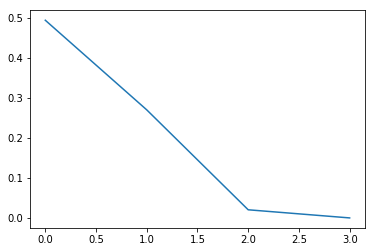

In [105]:
#Setting
m = 2
m_1 = 1
m_x = 1000
X = uniformSphere(m, m_x)
A = ortho_group.rvs(dim = m)# m orthogonal vectors with dim m, a_1, ..., a_m
A = np.transpose(A)
B = ortho_group.rvs(dim = m)[:m_1]#m_1 orthogonal vectors with dimension m b_1, ..., b_m_1
B = np.transpose(B)
hmm = ddf(X, A,B)
mak = [np.reshape(dd, (m**2,)) for dd in hmm]
M = np.transpose(np.array(mak))
M.shape
U,D,V = np.linalg.svd(M)
plt.plot(list(range(m**2)), D)

In [106]:
U_trunc = U[:,:2*m]
U_unvec = []
for i in range(2*m):
    U_unvec.append(np.reshape(U_trunc[:,i] , (m,m)))
    
    
for i in range(m):
    dist =[]
    for j in range(m+m_1):
        t = np.tensordot(A[:,i], A[:,i], axes=0) - U_unvec[j]
        t2 = -np.tensordot(A[:,i], A[:,i], axes=0) - U_unvec[j]
        d2 = np.linalg.norm(t2)
        d = np.linalg.norm(t)
        
        dist.append(np.min([d,d2]))
    print(dist, "\n")

[1.3688370673106183, 0.071943377800388633, 1.3896886530268064] 

[0.072498563237221994, 1.3679974704341167, 1.3903936537682631] 



dddf: 0/1000


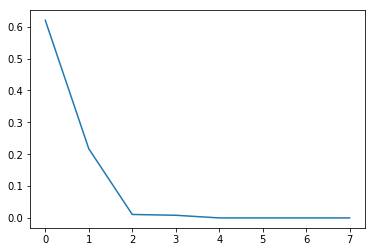

In [107]:
hum, info  = dddf(X,A,B)
mak = [np.reshape(dd, (m**3,)) for dd in hum]
M = np.transpose(np.array(mak))
M.shape
U,D,V = np.linalg.svd(M)
plt.plot(list(range(m**3)), D)

In [108]:
print(info)

[[0.026883319504130445, 0.24433171958887276, 0.00078760257967727134, -0.036790484788895537, 0.0015358036370937973, -0.11385621559466057], [0.017045902492154069, 0.24936352377384138, 0.00055758901653722313, -0.01258212557232959, 0.0012892144071589779, -0.12372947815960153], [0.016649263921789888, 0.24988298931190558, 0.00024066865660184929, 0.0054060424923921728, 0.00119575446014022, -0.12476606077281795], [0.016496673449707847, 0.24983925634881957, 0.00028390646137211901, 0.0063351600110673686, 0.0012523432231124813, -0.12467866772876751], [0.016595442743112195, 0.24987622759462488, 0.00024785915222138227, 0.0055598983544387489, 0.0011993295495484029, -0.12475254710689977], [0.020598094795954983, 0.24731678765264295, 0.0010108616955555611, -0.025621887174164342, 0.0013965304986233386, -0.11967677307629193], [0.026009049411277487, 0.24899547607313594, 0.00042521706469174754, -0.015783437509294659, 0.0016131591460516658, -0.12299700655618977], [0.017335420243748713, 0.23935737245282962, 

In [109]:
#U_trunc = U
U_trunc = U[:,:2*m]
U_unvec = []
"""for i in range(2*m):
    U_unvec.append(np.reshape(U_trunc[:,i] , (m,m)))
"""
    
for i in range(m):
    dist =[]
    for j in range(U_trunc.shape[1]):
        a = tensor3(A[:,i], A[:,i], A[:,i])
        av = np.reshape(a, m**3)
        t =  av - U_trunc[:,j]
        t2 = -av - U_trunc[:,j]
        d2 = np.linalg.norm(t2)
        d = np.linalg.norm(t)
        
        dist.append(np.min([d,d2]))
    print(np.min(dist), "\n")

0.422574855882 

0.422685648445 



In [110]:
stuf = np.array(info)

In [111]:
np.mean(stuf, axis=0)

array([ 0.01989025,  0.24616804,  0.00092962, -0.02216251,  0.00130598,
       -0.11752067])

In [89]:
np.linalg.norm(tensor3(A[:,0],A[:,2]+A[:,1],A[:,1]))

1.4142135623730951